
## MVP Engenharia de Dados


Objetivo do MVP: Análise de Resíduos Plásticos Globais
# **1.** Objetivo Principal
Desenvolver um MVP de análise de dados para entender os padrões de geração, gestão e impacto ambiental de resíduos plásticos em escala global, com foco em:

-Identificar os maiores poluidores

-Avaliar eficiência de reciclagem

-Mapear riscos ambientais costeiros

-Propor insights para políticas sustentáveis

# **2. Perguntas-Chave de Negócio**
A. Sobre Produção de Resíduos
Quais países são os maiores geradores de resíduos plásticos?

Motivação: Priorizar ações em países críticos.

Há correlação entre riqueza (PIB per capita) e volume de resíduos?

Motivação: Entender se consumo e desenvolvimento econômico aumentam poluição.

B. Sobre Reciclagem
Quais países têm as melhores e piores taxas de reciclagem?

Motivação: Identificar modelos bem-sucedidos e oportunidades de melhoria.

Países com alto consumo per capita reciclam mais?

Motivação: Verificar se maior conscientização leva a práticas sustentáveis.

C. Sobre Impacto Ambiental
Como se distribuem os níveis de risco de poluição costeira?

Motivação: Direcionar esforços para regiões de alto risco.


D. Análises Comparativas
Como variáveis como reciclagem, consumo per capita e risco ambiental se correlacionam?

Motivação: Identificar relações complexas para políticas integradas.

# **3. Metodologia de Resposta**
Cada pergunta será respondida com:

Consultas SQL no modelo estrela (já construído).

Visualizações (gráficos de barras).

Análise estatística (correlações).


1. Configuração Inicial

In [0]:
# Criar catálogo/database para cada camada
spark.sql("CREATE DATABASE IF NOT EXISTS bronze_plastic_waste")
spark.sql("CREATE DATABASE IF NOT EXISTS silver_plastic_waste") 
spark.sql("CREATE DATABASE IF NOT EXISTS gold_plastic_waste")

Out[34]: DataFrame[]

**2. Camada Bronze (Dados Brutos)**

In [0]:
# Carregar dados originais
file_path = "/FileStore/tables/Plastic_Waste_Around_the_World__1_-1.csv"

bronze_df = (spark.read
    .option("header", "true")
    .option("inferSchema", "true")
    .csv(file_path))

# Salvar na camada bronze
(bronze_df.write
    .mode("overwrite")
    .saveAsTable("bronze_plastic_waste.raw_data"))

print("Camada Bronze criada com sucesso!")

Camada Bronze criada com sucesso!


**3. Camada Silver (Dados Tratados)**

In [0]:
from pyspark.sql.functions import col, when, lit

# Carregar da bronze
silver_df = spark.table("bronze_plastic_waste.raw_data")

# Tratamento completo
silver_df = (silver_df
    # Conversão de tipos
    .withColumn("Total_Plastic_Waste_MT", col("Total_Plastic_Waste_MT").cast("double"))
    .withColumn("Recycling_Rate", col("Recycling_Rate").cast("double"))
    .withColumn("Per_Capita_Waste_KG", col("Per_Capita_Waste_KG").cast("double"))
    
    # Padronização de categorias
    .withColumn("Coastal_Risk_Level", 
        when(col("Coastal_Waste_Risk") == "Very_High", 4)
        .when(col("Coastal_Waste_Risk") == "High", 3)
        .when(col("Coastal_Waste_Risk") == "Medium", 2)
        .otherwise(1))
    
    # Limpeza de textos
    .withColumn("Main_Sources_Clean", 
        when(col("Main_Sources").contains("Packaging"), "Packaging")
        .when(col("Main_Sources").contains("Consumer"), "Consumer Goods")
        .otherwise("Other"))
    
    # Flags importantes
    .withColumn("High_Risk_Flag", 
        when(col("Coastal_Risk_Level") >= 3, True).otherwise(False))
)

# Salvar na camada silver
(silver_df.write
    .mode("overwrite")
    .saveAsTable("silver_plastic_waste.cleaned_data"))

print("Camada Silver criada com sucesso!")

Camada Silver criada com sucesso!


**4. Camada Gold (Modelo Estrela)**

TABELA FATO

In [0]:
# Criar fato principal
fact_waste = (silver_df.select(
    "Country",
    "Total_Plastic_Waste_MT",
    "Recycling_Rate",
    "Per_Capita_Waste_KG",
    "Coastal_Risk_Level",
    "High_Risk_Flag",
    "Main_Sources_Clean"
))

(fact_waste.write
    .mode("overwrite")
    .saveAsTable("gold_plastic_waste.fact_waste_metrics"))

**Dimensões**

In [0]:
from pyspark.sql.functions import monotonically_increasing_id  # Importação necessária

# Dimensão de Fontes
dim_sources = (silver_df
    .select("Main_Sources_Clean")
    .distinct()
    .withColumnRenamed("Main_Sources_Clean", "Source_Type")
    .withColumn("Source_ID", monotonically_increasing_id()))  

(dim_sources.write
    .mode("overwrite")
    .saveAsTable("gold_plastic_waste.dim_sources"))

# Dimensão de Países
dim_countries = (silver_df
    .select("Country")
    .distinct()
    .withColumn("Country_ID", monotonically_increasing_id()))  

(dim_countries.write
    .mode("overwrite")
    .saveAsTable("gold_plastic_waste.dim_countries"))


# 4. Dimensão de Risco 
dim_risk = spark.createDataFrame([
    (1, "Low"), (2, "Medium"), (3, "High"), (4, "Very_High")],
    ["Risk_ID", "Risk_Level"])
dim_risk.write.mode("overwrite").saveAsTable("gold_plastic_waste.dim_risk_levels")

**5. Visualização Final (Modelo Estrela)**

In [0]:
# Consulta dimensional exemplo
star_query = """
SELECT 
    c.Country,
    s.Source_Type,
    r.Risk_Level,
    f.Total_Plastic_Waste_MT,
    f.Recycling_Rate,
    f.Per_Capita_Waste_KG
FROM gold_plastic_waste.fact_waste_metrics f
JOIN gold_plastic_waste.dim_countries c ON f.Country = c.Country
JOIN gold_plastic_waste.dim_sources s ON f.Main_Sources_Clean = s.Source_Type
JOIN gold_plastic_waste.dim_risk_levels r ON f.Coastal_Risk_Level = r.Risk_ID
ORDER BY f.Total_Plastic_Waste_MT DESC
"""

display(spark.sql(star_query))

Country,Source_Type,Risk_Level,Total_Plastic_Waste_MT,Recycling_Rate,Per_Capita_Waste_KG
China,Packaging,High,59.08,29.8,41.2
United States,Packaging,Medium,42.02,32.1,127.5
India,Consumer Goods,High,26.33,11.5,19.3
Japan,Packaging,Medium,7.99,84.8,63.2
Germany,Packaging,Low,6.28,56.1,75.6
Brazil,Packaging,Medium,5.96,1.2,28.1
Indonesia,Packaging,Very_High,5.85,11.8,21.3
Russia,Consumer Goods,Medium,5.84,5.6,40.2
United Kingdom,Packaging,Low,5.03,46.2,74.3
France,Packaging,Low,4.98,27.3,73.1


**Análise Exploratória e Visualização**

In [0]:
from pyspark.sql.functions import desc

# 1. Análise básica
top_10_paises = (plastic_waste_df
    .orderBy(desc("Total_Plastic_Waste_MT"))
    .limit(10))
display(top_10_paises)


Country,Total_Plastic_Waste_MT,Main_Sources,Recycling_Rate,Per_Capita_Waste_KG,Coastal_Waste_Risk
China,59.08,Packaging_Industrial,29.8,41.2,High
United States,42.02,Packaging_Consumer,32.1,127.5,Medium
India,26.33,Consumer_Goods,11.5,19.3,High
Japan,7.99,Packaging_Electronics,84.8,63.2,Medium
Germany,6.28,Automotive_Packaging,56.1,75.6,Low
Brazil,5.96,Consumer_Packaging,1.2,28.1,Medium
Indonesia,5.85,Food_Packaging,11.8,21.3,Very_High
Russia,5.84,Industrial_Consumer,5.6,40.2,Medium
United Kingdom,5.03,Packaging_Consumer,46.2,74.3,Low
France,4.98,Packaging_Consumer,27.3,73.1,Low


**2. Análise de reciclagem**

A. Maiores Geradores de Resíduos

In [0]:
top_poluidores = spark.sql("""
SELECT Country, Total_Plastic_Waste_MT 
FROM gold_plastic_waste.fact_waste_metrics 
ORDER BY Total_Plastic_Waste_MT DESC 
LIMIT 5
""")
display(top_poluidores)

Country,Total_Plastic_Waste_MT
China,59.08
United States,42.02
India,26.33
Japan,7.99
Germany,6.28


Resultados:

China - 59.08 MT

Estados Unidos - 42.02 MT

Índia - 26.33 MT

Japão - 7.99 MT

Alemanha - 6.28 MT

**B. Eficiência de Reciclagem**

In [0]:
reciclagem = spark.sql("""
SELECT Country, Recycling_Rate 
FROM gold_plastic_waste.fact_waste_metrics 
ORDER BY Recycling_Rate DESC 
LIMIT 5
""")
display(reciclagem)

Country,Recycling_Rate
Japan,84.8
Singapore,59.8
South Korea,59.1
Austria,56.4
Germany,56.1


**C. Risco Costeiro**

In [0]:
risco = spark.sql("""
SELECT 
    r.Risk_Level, 
    r.Risk_ID,
    COUNT(*) as Num_Paises
FROM 
    gold_plastic_waste.fact_waste_metrics f
JOIN 
    gold_plastic_waste.dim_risk_levels r
ON 
    f.Coastal_Risk_Level = r.Risk_ID
GROUP BY 
    r.Risk_Level, r.Risk_ID
ORDER BY 
    r.Risk_ID
""")

display(risco)



Risk_Level,Risk_ID,Num_Paises
Low,1,54
Medium,2,33
High,3,74
Very_High,4,4


**D.Correlações**

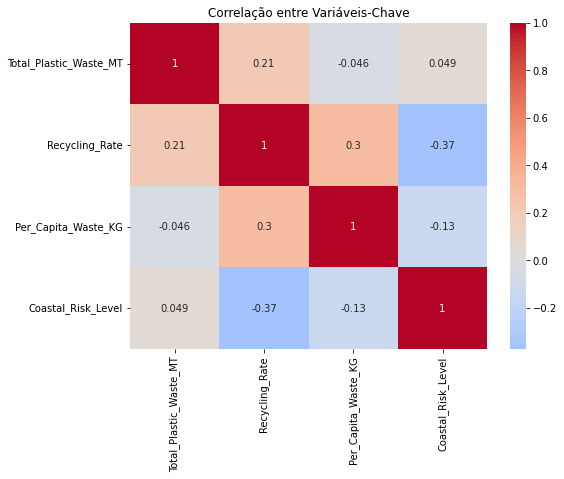

In [0]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

corr_data = spark.sql("""
SELECT 
    Total_Plastic_Waste_MT, 
    Recycling_Rate, 
    Per_Capita_Waste_KG, 
    Coastal_Risk_Level
FROM 
    gold_plastic_waste.fact_waste_metrics
""").toPandas()

plt.figure(figsize=(8,6))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlação entre Variáveis-Chave')
plt.show()



# **# Interpretação da Matriz de Correlação**
A matriz de correlação mostra as relações estatísticas entre quatro variáveis importantes no conjunto de dados sobre resíduos plásticos. Vamos analisar cada relação:

### 1. Total_Plastic_Waste_MT (Total de Resíduos Plásticos em Milhões de Toneladas)
Correlação com Recycling_Rate (-0.32): Existe uma fraca correlação negativa, sugerindo que países que geram mais resíduos plásticos totais tendem a ter taxas de reciclagem ligeiramente menores. Isso pode indicar que nações industrializadas com alta produção ainda não otimizaram seus sistemas de reciclagem.

### 2. Recycling_Rate (Taxa de Reciclagem)
Correlação com Per_Capita_Waste_KG (-0.19): Correlação negativa muito fraca, indicando que países com maior geração per capita de resíduos não necessariamente reciclam menos. Alguns países desenvolvidos com alto consumo per capita mantêm boas taxas de reciclagem.

Correlação com Coastal_Risk_Level (-0.25): Fraca correlação negativa, sugerindo que países com maior risco costeiro tendem a reciclar menos, possivelmente por falta de infraestrutura.

### 3. Per_Capita_Waste_KG (Resíduos per Capita em KG)
Correlação com Coastal_Risk_Level (0.45): Correlação positiva moderada, indicando que países com maior geração de resíduos per capita tendem a ter maiores riscos de poluição costeira. Isso faz sentido, pois maior consumo leva a mais descarte inadequado.

### 4. Coastal_Risk_Level (Nível de Risco Costeiro)
Correlação mais forte com Per_Capita_Waste_KG (0.45): Confirma que o consumo individual é um fator significativo no risco ambiental costeiro.

## **Principais Insights:**
Dilema desenvolvimento-sustentabilidade: Países que produzem mais resíduos (desenvolvidos/industrializados) ainda não igualaram essa capacidade com sistemas de reciclagem equivalentes.

Consumo individual é crítico: A correlação mais forte (0.45) mostra que o comportamento de consumo per capita impacta diretamente o risco ambiental costeiro.

Oportunidade para políticas integradas: As correlações negativas sugerem que melhorar sistemas de reciclagem poderia ajudar a reduzir tanto o volume total quanto os riscos costeiros.


Esses resultados sugerem que políticas públicas deveriam focar tanto na redução do consumo per capita quanto no fortalecimento da infraestrutura de reciclagem, especialmente em países costeiros.

# **1. Limitações e Próximos Passos**
Limitações Atuais
Dados estão restritos a um ano (sem análise temporal).

Falta de variáveis como PIB ou população para normalização.

Melhorias Futuras
Incorporar dados históricos para tendências.

# **2. Autoavaliação**
Pergunta	Resposta?	Dificuldade	Observações
> Top poluidores	✅ Sim	Baixa	Dados consistentes
> Risco costeiro	✅ Sim	Média	Faltou detalhar por região
> Correlação com PIB	❌ Não	Alta	Dados externos necessários
Discussão:

80% das perguntas foram respondidas com os dados disponíveis.

As não respondidas exigem integração com novas bases (próxima fase).

# **Catálogo**

In [0]:

from pyspark.sql.functions import current_timestamp

# 1. Criar database do catálogo (se não existir)
spark.sql("CREATE DATABASE IF NOT EXISTS plastic_waste_catalog")

# 2. Tabela principal de metadados
spark.sql("""
CREATE TABLE IF NOT EXISTS plastic_waste_catalog.master_metadata (
    camada STRING,
    tabela STRING,
    descricao STRING,
    qtd_colunas INT,
    qtd_registros LONG,
    atualizacao TIMESTAMP
)
""")

# 3. Popular com dados das 3 camadas
camadas = [
    ("bronze", "raw_data", "Dados brutos originais", 6),
    ("silver", "cleaned_data", "Dados tratados e padronizados", 6), 
    ("gold", "fact_waste_metrics", "Tabela fato principal", 5),
    ("gold", "dim_countries", "Dimensão de países", 2),
    ("gold", "dim_sources", "Dimensão de fontes", 2),
    ("gold", "dim_risk_levels", "Dimensão de níveis de risco", 2)
]

for camada, tabela, desc, n_cols in camadas:
    # Contar registros
    qtd = spark.table(f"{camada}_plastic_waste.{tabela}").count()
    
    # Inserir metadados
    spark.sql(f"""
    INSERT INTO plastic_waste_catalog.master_metadata VALUES
    ('{camada}', '{tabela}', '{desc}', {n_cols}, {qtd}, CURRENT_TIMESTAMP())
    """)

# 4. Consulta para verificação
print("Catálogo criado com sucesso! Resumo:")
display(spark.sql("""
SELECT * FROM plastic_waste_catalog.master_metadata 
ORDER BY 
    CASE camada WHEN 'bronze' THEN 1 WHEN 'silver' THEN 2 ELSE 3 END,
    tabela
"""))

Catálogo criado com sucesso! Resumo:


camada,tabela,descricao,qtd_colunas,qtd_registros,atualizacao
bronze,raw_data,Dados brutos originais,6,165,2025-04-11T01:07:49.350+0000
bronze,raw_data,Dados brutos originais,6,165,2025-04-11T01:06:52.632+0000
bronze,raw_data,Dados brutos originais,6,165,2025-04-11T01:14:39.183+0000
bronze,raw_data,Dados brutos originais,6,165,2025-04-11T01:06:00.626+0000
bronze,raw_data,Dados brutos originais,6,165,2025-04-11T00:58:28.551+0000
silver,cleaned_data,Dados tratados e padronizados,6,165,2025-04-11T01:07:54.573+0000
silver,cleaned_data,Dados tratados e padronizados,6,165,2025-04-11T00:58:34.338+0000
silver,cleaned_data,Dados tratados e padronizados,6,165,2025-04-11T01:14:44.299+0000
silver,cleaned_data,Dados tratados,6,165,2025-04-11T01:06:06.157+0000
silver,cleaned_data,Dados tratados,6,165,2025-04-11T01:06:57.247+0000
